## CEREN DOGAN - INDIVIDUAL PROJECT - MSBA 207

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf
import dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from mord import LogisticIT


In [ ]:
DATA = Path(r'C:\Users\ceren\Desktop\dmba')

sba_df = pd.read_csv(DATA / 'SBAnational.csv')
sba_df.head(5)

## 1)

__How is the outcome variable MIS_Status distributed? Identify predictors that may help predict MIS_Status using descriptive statistics and visualization.__

In [104]:
sba_df .MIS_Status.value_counts()

MIS_Status
P I F     739609
CHGOFF    157558
Name: count, dtype: int64

In [106]:
sba_df['MIS_Status_New'] = sba_df['MIS_Status'].map({'P I F': 0, 'CHGOFF': 1})
sba_df['LowDoc'] = sba_df['LowDoc'].str.strip().map({'N': 0, 'Y': 1})
sba_df['RevLineCr'] = sba_df['RevLineCr'].str.strip().map({'N': 0, 'Y': 1})


drop_cols = [
    'LoanNr_ChkDgt', 'Name', 'Zip', 'City',
    'DisbursementDate', 'ChgOffDate', 'ApprovalFY', 'MIS_Status',
]
sba_df = sba_df.drop(columns=[col for col in drop_cols if col in sba_df.columns])

sba_df.head(3)


,State,Bank,BankState,NAICS,ApprovalDate,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,MIS_Status_New
0,IN,FIFTH THIRD BANK,OH,451120,28-Feb-97,84,4,2.0,0,0,1,0,0.0,1.0,"$60,000.00",$0.00,$0.00,"$60,000.00","$48,000.00",0.0
1,IN,1ST SOURCE BANK,IN,722410,28-Feb-97,60,2,2.0,0,0,1,0,0.0,1.0,"$40,000.00",$0.00,$0.00,"$40,000.00","$32,000.00",0.0
2,IN,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,180,7,1.0,0,0,1,0,0.0,0.0,"$287,000.00",$0.00,$0.00,"$287,000.00","$215,250.00",0.0


In [108]:
sba_df.dtypes

State                 object
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr            float64
LowDoc               float64
DisbursementGross     object
BalanceGross          object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
MIS_Status_New       float64
dtype: object

In [110]:
sba_df.MIS_Status_New.value_counts(normalize=True)

MIS_Status_New
0.0    0.824383
1.0    0.175617
Name: proportion, dtype: float64

__I pick my sample size as CALIFORNIA clients.__

In [ ]:
sba_CALIFORNIA = sba_df[sba_df['State'] == 'CA'].copy()
sba_df1 = sba_CALIFORNIA .dropna()

sba_df1 = sba_df1.sample(n=5000, random_state=1).reset_index(drop=True)

numeric_vars = ['Term', 'NoEmp', 'CreateJob', 'DisbursementGross']
categorical_vars = ['LowDoc','NewExist', 'RevLineCr', 'UrbanRural']

print(sba_df1[numeric_vars].describe())

sba_df1[numeric_vars].hist(bins=20, figsize=(12,10))
plt.suptitle('Histograms of Numeric possible Predictors')
plt.show()


LowDoc Value Counts:
LowDoc
0.0    78012
1.0     3179
Name: count, dtype: int64
LowDoc Proportions:
LowDoc
0.0    0.960845
1.0    0.039155
Name: proportion, dtype: float64

NewExist Value Counts:
NewExist
1.0    67824
2.0    13256
0.0      111
Name: count, dtype: int64
NewExist Proportions:
NewExist
1.0    0.835364
2.0    0.163269
0.0    0.001367
Name: proportion, dtype: float64

RevLineCr Value Counts:
RevLineCr
0.0    51544
1.0    29647
Name: count, dtype: int64
RevLineCr Proportions:
RevLineCr
0.0    0.634849
1.0    0.365151
Name: proportion, dtype: float64

UrbanRural Value Counts:
UrbanRural
1    44818
0    32680
2     3693
Name: count, dtype: int64
UrbanRural Proportions:
UrbanRural
1    0.552007
0    0.402508
2    0.045485
Name: proportion, dtype: float64


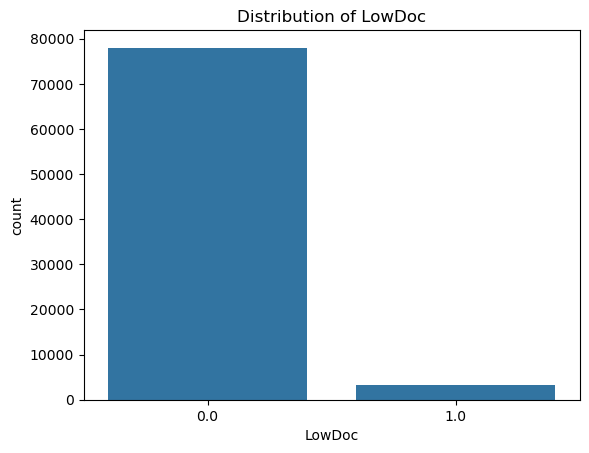

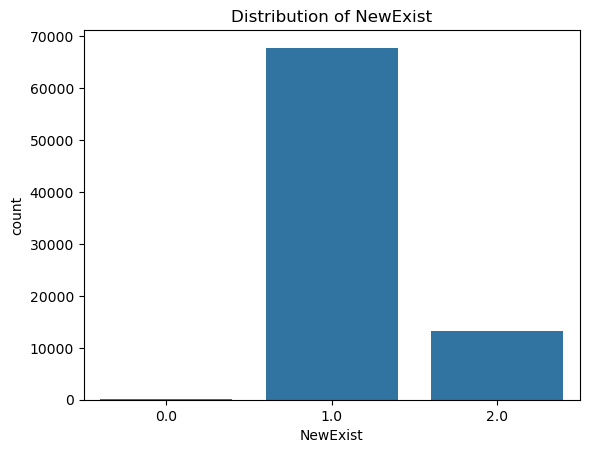

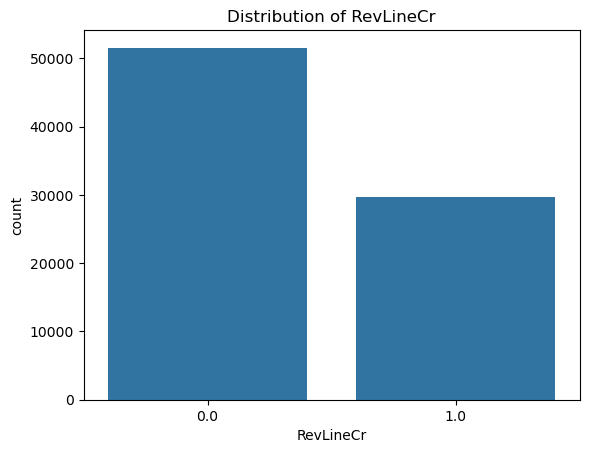

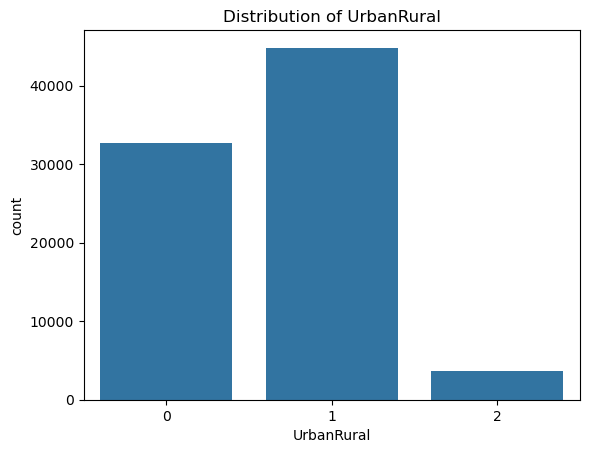

In [114]:
for var in categorical_vars:
    print(f'\n{var} Value Counts:')
    print(sba_df1[var].value_counts(dropna=False))
    print(f'{var} Proportions:')
    print(sba_df1[var].value_counts(normalize=True, dropna=False)) 
    
for var in categorical_vars:
    sns.countplot(x=var, data=sba_df1)
    plt.title(f'Distribution of {var}')
    plt.show()


## 2) 

__Divide the data into training and validation partitions. Choose appropriate predictors and develop classification models using the following methods (implement all the following methods for comparison) to classify the loan applications as “higher risk” or “lower risk” for loan approval:__

- kNN

- Classification trees (single tree, bagging, boosting, and random forest)

- Logit model (including Lasso, Ridge, and ElasticNet)

- Neural networks

- Discriminant analysis

__Lower risk = Paid (0)__      When a model predicts class 0, it's saying "This loan looks low risk, approve it"

__Higher risk = Default(1)__   When a model predicts class 1, it's saying "This loan looks high risk, consider denying"


In [118]:
selected_numeric = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob']
selected_categorical = ['NewExist', 'RevLineCr']


predictors_final = selected_numeric + selected_categorical


X = sba_df1[predictors_final]
y = sba_df1['MIS_Status_New']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)


In [120]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

__KNN__

In [ ]:
param_grid = {'n_neighbors': list(range(1, 21))}
gridSearch = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=10,
    n_jobs=-1,
    return_train_score=True
)
gridSearch.fit(X_train_scaled, y_train)

best_k = gridSearch.best_params_['n_neighbors']
print(f"Best k from GridSearchCV: {best_k}")

knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

y_probs = knn_model.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"kNN Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))


#LIFT/ GAIN CHARTS

proba = knn_model.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': knn_model.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


__Single Tree__

Decision Tree Best threshold: 0.10, Max profit: $1,959,780.40
Confusion Matrix (Accuracy 0.9080)

        Prediction
 Actual    Paid Default
   Paid     266      22
Default      26     208
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       288
           1       0.90      0.89      0.90       234

    accuracy                           0.91       522
   macro avg       0.91      0.91      0.91       522
weighted avg       0.91      0.91      0.91       522



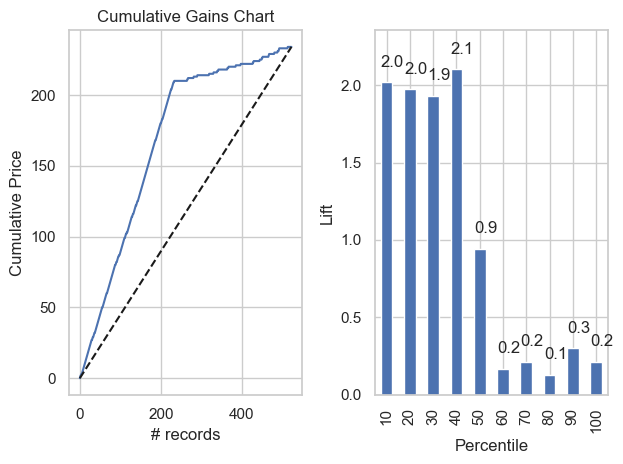

In [325]:
singleTree = DecisionTreeClassifier(random_state=1)
singleTree.fit(X_train_scaled, y_train)

y_probs = singleTree.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Decision Tree Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))



#LIFT/ GAIN CHARTS

proba = singleTree.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': singleTree.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


__Bagging__

Bagging Best threshold: 0.17, Max profit: $2,477,407.10
Confusion Matrix (Accuracy 0.9272)

        Prediction
 Actual    Paid Default
   Paid     255      33
Default       5     229
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       288
           1       0.87      0.98      0.92       234

    accuracy                           0.93       522
   macro avg       0.93      0.93      0.93       522
weighted avg       0.93      0.93      0.93       522



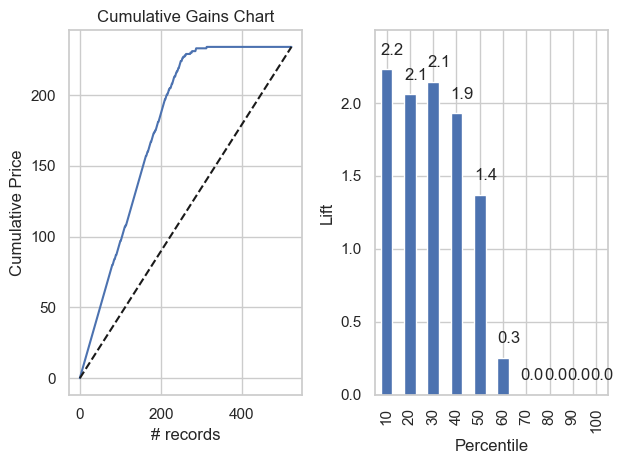

In [328]:
bagging_sba = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion='entropy', random_state=1),
    n_estimators=500,
    random_state=1
)
bagging_sba.fit(X_train_scaled, y_train)

y_probs = bagging_sba.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Bagging Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))


#LIFT/ GAIN CHARTS
proba = bagging_sba.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': bagging_sba.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


__Boosting - (AdaBoost, Gradient Boosting and XGBoost)__

AdaBoost Best threshold: 0.45, Max profit: $2,389,510.25
Confusion Matrix (Accuracy 0.8908)

        Prediction
 Actual    Paid Default
   Paid     235      53
Default       4     230
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       288
           1       0.81      0.98      0.89       234

    accuracy                           0.89       522
   macro avg       0.90      0.90      0.89       522
weighted avg       0.91      0.89      0.89       522



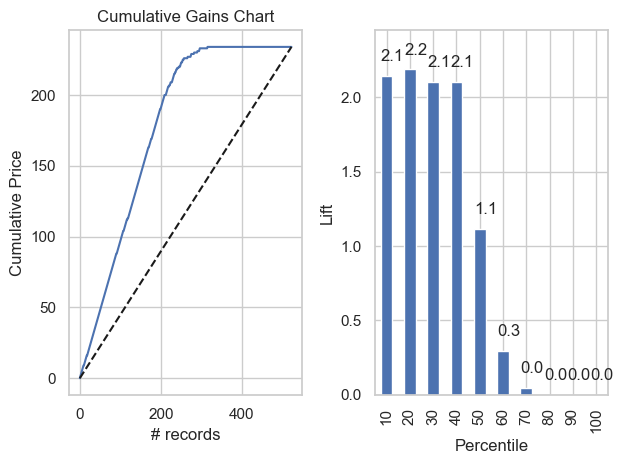

In [331]:
#     AdaBoost

boost_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=1),
    algorithm='SAMME',
    n_estimators=100,
    random_state=1
)
boost_ada.fit(X_train_scaled, y_train)

y_probs = boost_ada.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"AdaBoost Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))


#LIFT/ GAIN CHARTS
proba = boost_ada.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted':boost_ada.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()



Gradient Boosting Best threshold: 0.28, Max profit: $2,456,604.55
Confusion Matrix (Accuracy 0.9195)

        Prediction
 Actual    Paid Default
   Paid     251      37
Default       5     229
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       288
           1       0.86      0.98      0.92       234

    accuracy                           0.92       522
   macro avg       0.92      0.93      0.92       522
weighted avg       0.93      0.92      0.92       522



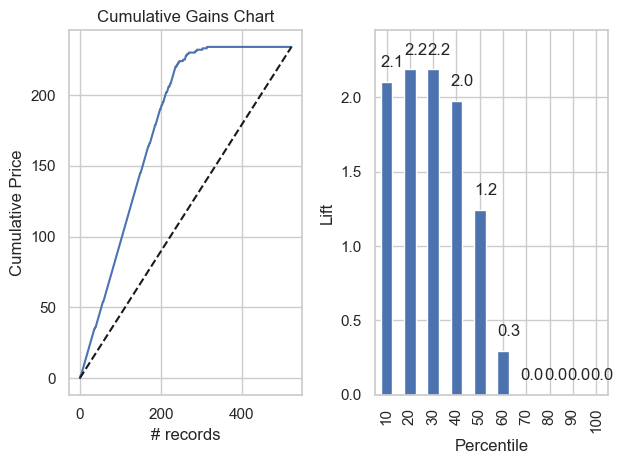

In [333]:
#   Gradient Boosting 

boost_gb = GradientBoostingClassifier(random_state=1)
boost_gb.fit(X_train_scaled, y_train)

y_probs = boost_gb.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Gradient Boosting Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))


#LIFT/ GAIN CHARTS
proba = boost_gb.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': boost_gb.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


In [161]:
#  XG BOOST

!pip install xgboost

C:\Users\ceren\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:01:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best threshold: 0.10, Max profit: $2,389,067.15
Confusion Matrix (Accuracy 0.8889)

        Prediction
 Actual    Paid Default
   Paid     234      54
Default       4     230
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       288
           1       0.81      0.98      0.89       234

    accuracy                           0.89       522
   macro avg       0.90      0.90      0.89       522
weighted avg       0.91      0.89      0.89       522



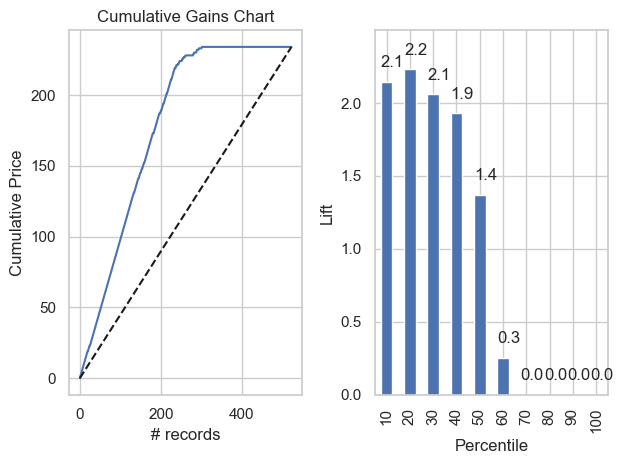

In [335]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    random_state=1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)

y_probs = xgb_model.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"XGBoost Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))

#LIFT/ GAIN CHARTS
proba = xgb_model.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': xgb_model.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


__Random Forest__

Random Forest Best threshold: 0.20, Max profit: $2,463,978.05
Confusion Matrix (Accuracy 0.9195)

        Prediction
 Actual    Paid Default
   Paid     250      38
Default       4     230
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       288
           1       0.86      0.98      0.92       234

    accuracy                           0.92       522
   macro avg       0.92      0.93      0.92       522
weighted avg       0.93      0.92      0.92       522



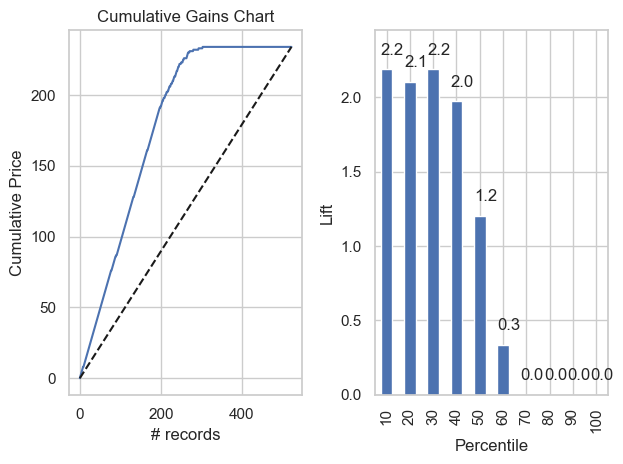

In [338]:
rfModel_sba = RandomForestClassifier(n_estimators=500, random_state=1)
rfModel_sba.fit(X_train_scaled, y_train)

y_probs = rfModel_sba.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Random Forest Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))

#LIFT/ GAIN CHARTS
proba = rfModel_sba.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': rfModel_sba.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

__Logit model (including Lasso, Ridge, and ElasticNet)__

Logistic Regression Best threshold: 0.23, Max profit: $2,264,557.20
Confusion Matrix (Accuracy 0.8333)

        Prediction
 Actual    Paid Default
   Paid     211      77
Default      10     224
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       288
           1       0.74      0.96      0.84       234

    accuracy                           0.83       522
   macro avg       0.85      0.84      0.83       522
weighted avg       0.86      0.83      0.83       522



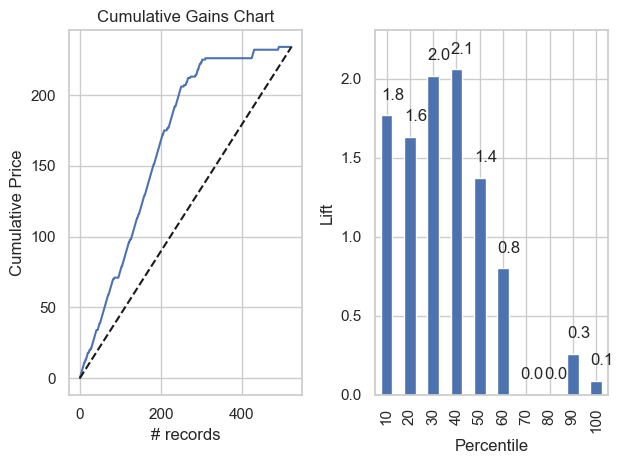

In [341]:
logit_model = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    max_iter=5000,
    random_state=1
)
logit_model.fit(X_train_scaled, y_train)

y_probs = logit_model.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Logistic Regression Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))

proba = logit_model.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': logit_model.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


LASSO Logistic Regression Best threshold: 0.44, Max profit: $2,268,503.25
Confusion Matrix (Accuracy 0.8851)

        Prediction
 Actual    Paid Default
   Paid     241      47
Default      13     221
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       288
           1       0.82      0.94      0.88       234

    accuracy                           0.89       522
   macro avg       0.89      0.89      0.88       522
weighted avg       0.89      0.89      0.89       522



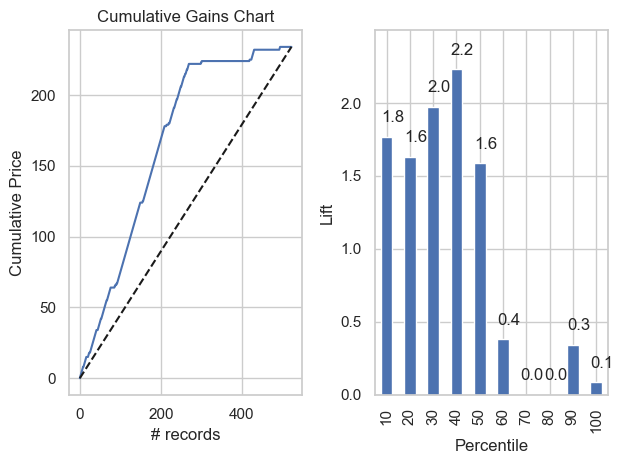

In [343]:
# LASSO
logit_lasso = LogisticRegressionCV(
    penalty="l1",
    solver='liblinear',
    cv=5,
    random_state=1,
    max_iter=5000
)
logit_lasso.fit(X_train_scaled, y_train)

y_probs = logit_lasso.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"LASSO Logistic Regression Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))


#LIFT/ GAIN CHARTS
proba = logit_lasso.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': logit_lasso.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


Ridge Logistic Regression Best threshold: 0.23, Max profit: $2,264,557.20
Confusion Matrix (Accuracy 0.8333)

        Prediction
 Actual    Paid Default
   Paid     211      77
Default      10     224
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       288
           1       0.74      0.96      0.84       234

    accuracy                           0.83       522
   macro avg       0.85      0.84      0.83       522
weighted avg       0.86      0.83      0.83       522



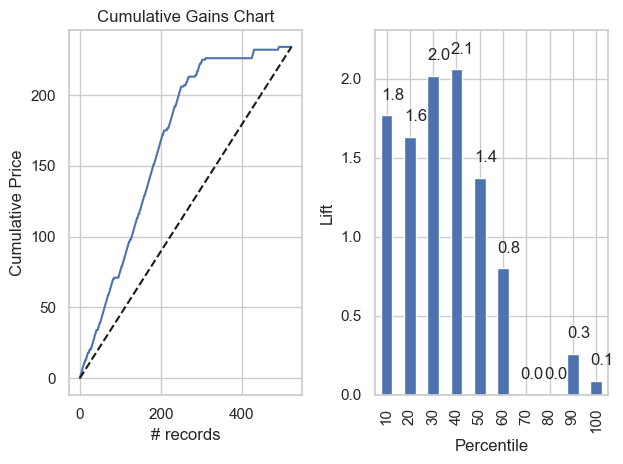

In [345]:
# RIDGE 
logit_ridge = LogisticRegression(
    penalty="l2",
    C=1e42,
    solver='liblinear',
    tol=1e-8,
    random_state=1
)
logit_ridge.fit(X_train_scaled, y_train)

y_probs = logit_ridge.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Ridge Logistic Regression Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))


#LIFT/ GAIN CHARTS
proba = logit_ridge.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': logit_ridge.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

Elastic Net Logistic Regression Best threshold: 0.23, Max profit: $2,264,557.20
Confusion Matrix (Accuracy 0.8333)

        Prediction
 Actual    Paid Default
   Paid     211      77
Default      10     224
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       288
           1       0.74      0.96      0.84       234

    accuracy                           0.83       522
   macro avg       0.85      0.84      0.83       522
weighted avg       0.86      0.83      0.83       522



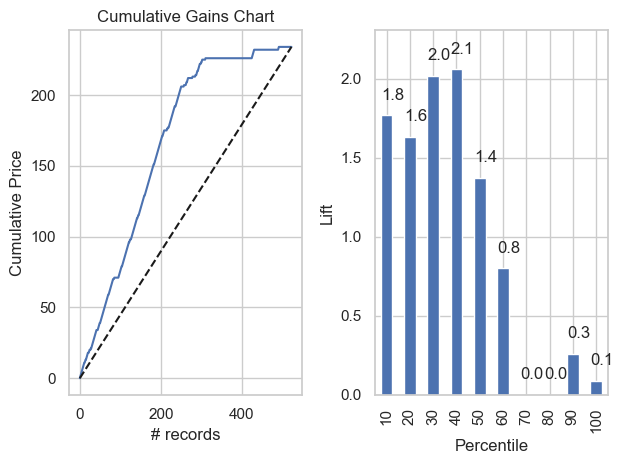

In [347]:
#    ELASTIC NET  
logit_elastic = LogisticRegressionCV(
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.5],
    cv=5,
    random_state=1,
    max_iter=5000
)
logit_elastic.fit(X_train_scaled, y_train)

y_probs = logit_elastic.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Elastic Net Logistic Regression Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))


#LIFT/ GAIN CHARTS
proba = logit_elastic.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': logit_elastic.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

__Neural Networks__

Neural Network Best threshold: 0.48, Max profit: $1,878,195.25
Confusion Matrix (Accuracy 0.8889)

        Prediction
 Actual    Paid Default
   Paid     246      42
Default      16     218
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       288
           1       0.84      0.93      0.88       234

    accuracy                           0.89       522
   macro avg       0.89      0.89      0.89       522
weighted avg       0.89      0.89      0.89       522

Best score:  0.9053554040895813
Best parameters:  {'hidden_layer_sizes': (9,)}


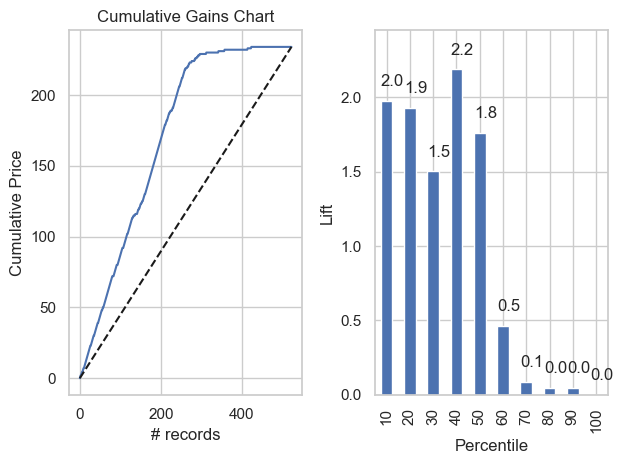

In [350]:
nn_model = MLPClassifier(
    hidden_layer_sizes=(5,),
    activation='relu',
    solver='lbfgs',
    max_iter=1000,
    random_state=1
)
nn_model.fit(X_train_scaled, y_train)

y_probs = nn_model.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Neural Network Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))

param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(1, 20)]
}
gridSearch = GridSearchCV(
    MLPClassifier(activation='relu', solver='lbfgs',
                  random_state=1, max_iter=10000),
    param_grid, cv=10, n_jobs=-1, return_train_score=True
)
gridSearch.fit(X_train_scaled, y_train)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)


#LIFT/ GAIN CHARTS
proba = nn_model.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': nn_model.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

__Discriminant analysis__

Discriminant Analysis Best threshold: 0.20, Max profit: $2,225,373.05
Confusion Matrix (Accuracy 0.8276)

        Prediction
 Actual    Paid Default
   Paid     207      81
Default       9     225
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       288
           1       0.74      0.96      0.83       234

    accuracy                           0.83       522
   macro avg       0.85      0.84      0.83       522
weighted avg       0.86      0.83      0.83       522



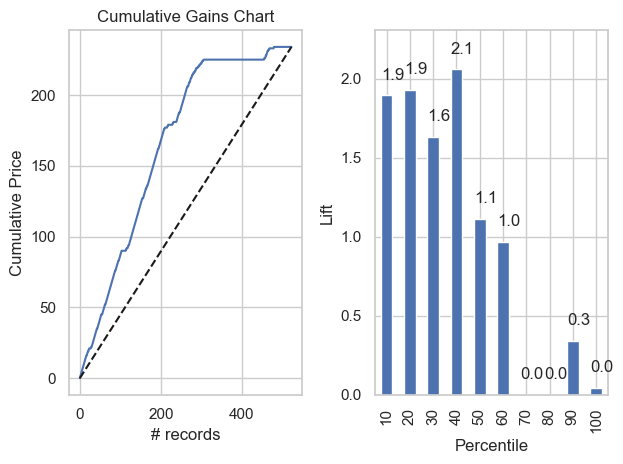

In [353]:

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_scaled, y_train)

y_probs = lda_model.predict_proba(X_valid_scaled)[:, 1]
disbursement = sba_df1.loc[y_valid.index, 'DisbursementGross']
thresholds = np.arange(0.1, 0.91, 0.01)
profits = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    profit = np.where(
        (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
        np.where(
            (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
            0
        )
    )
    profits.append(profit.sum())

best_index = np.argmax(profits)
best_threshold = thresholds[best_index]
best_profit = profits[best_index]

print(f"Discriminant Analysis Best threshold: {best_threshold:.2f}, Max profit: ${best_profit:,.2f}")

best_preds = (y_probs >= best_threshold).astype(int)
classificationSummary(y_valid, best_preds, class_names=['Paid', 'Default'])
print(classification_report(y_valid, best_preds))


#LIFT/ GAIN CHARTS
proba = lda_model.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': proba[:, 0],
    'p(1)': proba[:, 1],
    'predicted': lda_model.predict(X_valid_scaled)
})

df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], title=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show() 



__Net Profit Ranking: BAGGING has the highest net profit.__  

## 3)
__Use the estimated probabilities (propensities) from your chosen model as a basis for selecting the least risky loan application first, followed by more risky loan applications. Create a vector containing the net profit for each loan application in the validation set. Use this vector to create gains and lift charts for the validation set that incorporates the net profit.__

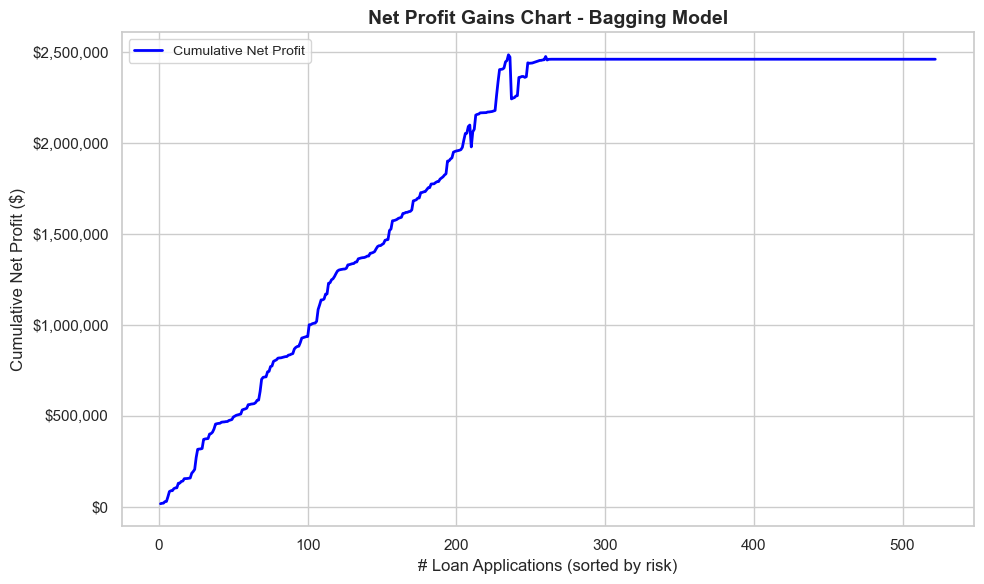

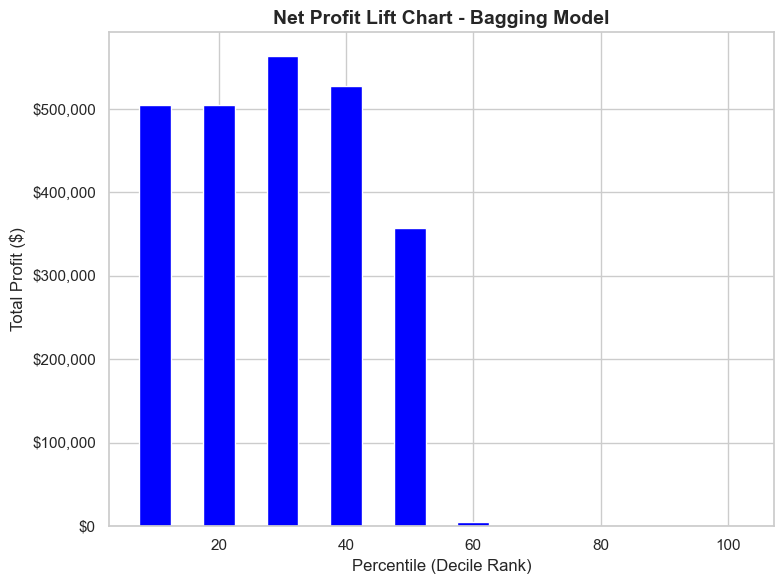

In [359]:
# Use Bagging 
y_probs = bagging_sba.predict_proba(X_valid_scaled)[:, 1]

y_pred = (y_probs >= best_threshold).astype(int)

#NET PROFIT
profit_vector = np.where(
    (y_pred == 0) & (y_valid == 0), 0.05 * disbursement,
    np.where(
        (y_pred == 0) & (y_valid == 1), -5 * 0.05 * disbursement,
        0
    )
)


results = pd.DataFrame({
    'actual': y_valid.values,
    'prob_default': y_probs,
    'net_profit': profit_vector
})


results_sorted = results.sort_values(by='prob_default').reset_index(drop=True)


results_sorted['cumulative_profit'] = results_sorted['net_profit'].cumsum()


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(
    np.arange(1, len(results_sorted) + 1),
    results_sorted['cumulative_profit'],
    label='Cumulative Net Profit',
    color='blue',
    linewidth=2
)
plt.xlabel('# Loan Applications (sorted by risk)', fontsize=12)
plt.ylabel('Cumulative Net Profit ($)', fontsize=12)
plt.title('Net Profit Gains Chart - Bagging Model', fontsize=14, weight='bold')
plt.legend(fontsize=10)
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Lift Chart - total profit by decile
results_sorted['decile'] = pd.qcut(results_sorted.index, 10, labels=False)
lift_data = results_sorted.groupby('decile')['net_profit'].sum()

plt.figure(figsize=(8, 6))
plt.bar((lift_data.index + 1) * 10, lift_data.values, width=5, color='blue')
plt.xlabel('Percentile (Decile Rank)', fontsize=12)
plt.ylabel('Total Profit ($)', fontsize=12)
plt.title('Net Profit Lift Chart - Bagging Model', fontsize=14, weight='bold')
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()


__a) How far into the validation data should you go to get maximum net profit?__

We should grant loans to the first ~210–250 applicants (the least risky ones) in the validation set to achieve maximum profit. TO find the exact amount;

In [363]:
max_index = results_sorted['cumulative_profit'].idxmax()
max_loan_number = max_index + 1 
print(f'Max net profit occurs after {max_loan_number} loan applications')

Max net profit occurs after 235 loan applications


__b)If this model is used to score to future loan applicants, what “probability of success” cut-off should be used in granting the loan and extending credit?__